<a href="https://colab.research.google.com/github/vsoos/CloudComputing/blob/main/ex5/5_notebook1_gpu/5_notebook1_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1 - Poetry generator



In [1]:
!pip install -q tensorflow

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from wordcloud import WordCloud
from keras import regularizers

In [3]:
folder_path = '/content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex5/5_notebook1_gpu'
os.chdir(folder_path)

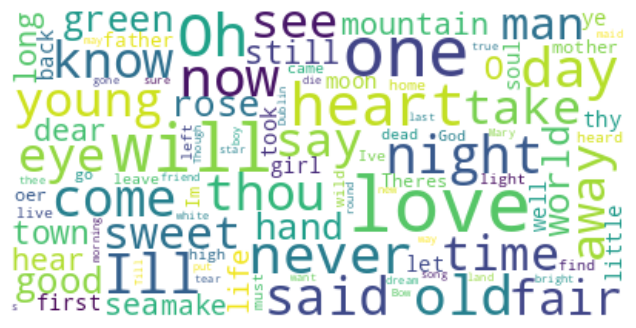

In [4]:
data = open('data/poem.txt', encoding="utf8").read()

# WordCloud
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="white").generate(data)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [5]:
display(data)

'Stay, I said\nto the cut flowers.\nThey bowed\ntheir heads lower.\nStay, I said to the spider,\nwho fled.\nStay, leaf.\nIt reddened,\nembarrassed for me and itself.\nStay, I said to my body.\nIt sat as a dog does,\nobedient for a moment,\nsoon starting to tremble.\nStay, to the earth\nof riverine valley meadows,\nof fossiled escarpments,\nof limestone and sandstone.\nIt looked back\nwith a changing expression, in silence.\nStay, I said to my loves.\nEach answered,\nAlways.\nTwo sets\nof family stories,\none long and detailed,\nabout many centuries\nof island ancestors, all living\non the same tropical farm...\nThe other side of the family tells stories\nthat are brief and vague, about violence\nin the Ukraine, which Dad\'s parents\nhad to flee forever, leaving all their\nloved ones\nbehind.\nThey don\'t even know if anyone\nsurvived.\nWhen Mami tells her flowery tales of Cuba,\nshe fills the twining words with relatives.\nBut when I ask my\nUkrainian-Jewish-American grandma\nabout her

In [6]:
# split text into lines, lowercase
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


## Tokenizing and embedding

In [7]:
# fit tokenizer on the text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(corpus)

# get total words in vocab
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)

Total Words: 3807


In [8]:
# create n-gram sequences
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences to make them same length
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(tf.keras.utils.pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))

# split into predictors and labels
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = tf.keras.utils.to_categorical(label, num_classes=total_words+1)

## Model

In [9]:
# Bi-Directional LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(total_words + 1, 100, input_shape=(max_sequence_len - 1,)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense((total_words + 1) // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(total_words + 1, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 15, 100)             │         380,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 15, 300)             │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1904)                │         192,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3808)                │       7,254,240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,288,944 (31.62 MB)

 Trainable params: 8,288,944 (31.62 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# Keras callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

In [11]:
history = model.fit(predictors, label, epochs=150, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.0568 - loss: 7.4115 - learning_rate: 0.0010
Epoch 2/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0602 - loss: 6.4980 - learning_rate: 0.0010
Epoch 3/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0668 - loss: 6.3491 - learning_rate: 0.0010
Epoch 4/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0688 - loss: 6.2178 - learning_rate: 0.0010
Epoch 5/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.0768 - loss: 6.1215 - learning_rate: 0.0010
Epoch 6/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0787 - loss: 6.0810 - learning_rate: 0.0010
Epoch 7/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.0857 - loss: 5.9386 - learning_rate: 0.0010
Epoch 8/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0952 - loss: 5.8343 - learning_rate: 0.0010
Epoch 9/150
510/510 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.1010 - loss: 5.7510 - learning_ra

## Poetry generation

In [12]:
seed_text = "The world"
next_words = 25
ouptut_text = ""

# generate words iteratively
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = tf.keras.utils.pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	# map predicted index to word
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print(seed_text)

The world seems bright and gay with more reuben’s housewife lies found her soul wed love the way of other world is cold clear mother of sea
